In [43]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output
import matplotlib.colors as mcolors

import gymnasium as gym
import torch
import numpy as np
from collections import defaultdict
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure
tensorboard_log = './ppotb'
device='cpu'
inbred_parent_data = np.load('../nbs/g2f_ch10.npy', allow_pickle=True)


In [44]:
@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 500000
    seed: int = 40
    #breeding sim parameters
    n_markers: int = 100
    starting_parents: int = 2
    pop_size: int = 100
    h2: float = 1.0
    max_generations:int = 5
    sparse_reward: bool = True
    starting_budget: int = 10000
    min_offspring: int = 20
    n_min: int = 1
    n_max: int = 2


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    
class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, haplotypes:torch.tensor, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.haplotypes: torch.Tensor = haplotypes
        self.device: torch.device = device

    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"

class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1.0):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        # Use torch.randn with a generator for reproducibility
        generator = torch.Generator(device=self.device)
        generator.manual_seed(torch.initial_seed())  # Use the seed set by torch.manual_seed()
        raw_effects = torch.randn(genome.n_markers, device=self.device, generator=generator)

        centered_effects = raw_effects - raw_effects.mean()
        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()
    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"

class SimOps:
    @staticmethod
    def score_population(population: Population, trait: Trait, h2: float = 1.0) -> torch.Tensor:
        dosages = population.haplotypes.sum(dim=1)
        breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)

        bv_var = breeding_values.var()
        if bv_var == 0 or h2 >= 1:
            return breeding_values

        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=population.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        return breeding_values + env_effects + trait.intercept


    @staticmethod
    def truncation_selection(population: Population, phenotypes: torch.Tensor, selection_intensity: float, return_indices: bool = False) -> torch.Tensor:
        assert 0 < selection_intensity <= 1, "Selection intensity must be between 0 and 1"
        assert population.haplotypes.shape[0] == phenotypes.shape[0], "Mismatch between population size and phenotypes"

        num_select = max(1, min(int(selection_intensity * phenotypes.shape[0]), phenotypes.shape[0] - 1))
#         print(f'DEBUG: num_select: {num_select}, population size: {phenotypes.shape[0]}')

        _, top_indices = torch.topk(phenotypes, num_select)
        if return_indices:
            return top_indices
        return population.haplotypes[top_indices]



    @staticmethod
    def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        num_parents, ploidy, num_markers = selected_haplotypes.shape

        # Repeat each parent's haplotypes num_gametes_per_parent times
        expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

        # The rest of the function remains largely the same, but operates on the expanded haplotypes
        total_gametes = num_parents * num_gametes_per_parent

        crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device, generator=torch.Generator(device=selected_haplotypes.device).manual_seed(torch.initial_seed()))
        crossover_points, _ = torch.sort(crossover_points, dim=1)

        crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
        crossover_mask.scatter_(1, crossover_points, 1)
        crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

        crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

        start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
        start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

        final_mask = crossover_mask ^ start_mask.bool()

        offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

        # Return only the first haplotype for each meiosis event
        return offspring_haplotypes[:, 0, :]
    @staticmethod
    def check_cuda(tensor: torch.Tensor, name: str) -> None:
        print(f"{name} is on: {tensor.device}")


    @staticmethod
    def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
        num_gametes, n_markers = gamete_tensor.shape

        # Double the gamete tensor until we have enough for the total crosses
        while num_gametes < 2 * total_crosses:
            gamete_tensor = torch.cat([gamete_tensor, gamete_tensor], dim=0)
            num_gametes *= 2

        # Randomly select gametes for crossing
        gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
        parent1_indices = gamete_indices[:total_crosses]
        parent2_indices = gamete_indices[total_crosses:2*total_crosses]

        # Create the new population haplotype tensor
        new_population = torch.stack([
            gamete_tensor[parent1_indices],
            gamete_tensor[parent2_indices]
        ], dim=1)

        return new_population
    
def grab_inbred_parents(starting_parents, genome, seed, device=device):
    np.random.seed(seed)
    torch.manual_seed(seed)
    inbred_data = inbred_parent_data
    if starting_parents > inbred_data.shape[0]:
        raise ValueError("Total parents requested exceed the number of available parents.")
    if genome.n_markers > inbred_data.shape[2]:
        raise ValueError("Total markers requested exceed the number of available markers.")
    
    # Randomly sample parents
    sampled_parents_indices = np.random.choice(inbred_data.shape[0], starting_parents, replace=False)
    sampled_parents = inbred_data[sampled_parents_indices, :, :]
    
    # Randomly sample markers
    sampled_markers_indices = np.random.choice(inbred_data.shape[2], genome.n_markers, replace=False)
    
    return torch.tensor(sampled_parents[:, :, sampled_markers_indices], device=device).float()

        

class SimParams:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Set the seed
        torch.manual_seed(config.seed)
        np.random.seed(config.seed)
        random.seed(config.seed)
        
        self.genome = Genome(config.n_markers)
        self.population = Population(config.pop_size, grab_inbred_parents(5, self.genome, config.seed), self.genome, device)
        
        f1 = self.perform_meiosis(self.population.haplotypes, num_crossovers=3, num_gametes_per_parent=((2000//self.population.haplotypes.shape[0]) *self.population.haplotypes.shape[0] + 100))
        self.create_next_generation(f1, total_crosses=2000)
        
        num_gametes_per_parent = (self.population.haplotypes.shape[0] / config.pop_size) + 2 
        segregating_pop = self.perform_meiosis(self.population.haplotypes, num_crossovers=3, num_gametes_per_parent=100)
        self.create_next_generation(segregating_pop, total_crosses=config.pop_size)
        
        self.trait = Trait(self.genome, self.population)
        
        # Calculate initial statistics for normalization
        initial_phenotypes = self.score_population()
        self.initial_max_phenotype = initial_phenotypes.max().item()
        self.initial_phenotype_std = initial_phenotypes.std().item()


    
    def score_population(self, h2: Optional[float] = None) -> torch.Tensor:
        h2 = h2 if h2 is not None else self.config.h2
        return SimOps.score_population(self.population, self.trait, h2)

    def truncation_selection(self, selection_intensity: Optional[float] = None, phenotypes: Optional[torch.Tensor] = None, return_indices: bool = False) -> torch.Tensor:
        selection_intensity = selection_intensity if selection_intensity is not None else self.config.selection_intensity
        if phenotypes is None:
            phenotypes = self.score_population()
        return SimOps.truncation_selection(self.population, phenotypes, selection_intensity, return_indices)

    def check_device(self) -> None:
        SimOps.check_cuda(self.population.haplotypes, "Population haplotypes")
        SimOps.check_cuda(self.trait.effects, "Trait effects")
        SimOps.check_cuda(self.trait.intercept, "Trait intercept")

    def to(self, device: torch.device) -> 'SimParams':
        self.device = device
        self.population = self.population.to(device)
        self.trait = self.trait.to(device)
        return self
    def perform_meiosis(self, selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        return SimOps.meiosis(selected_haplotypes, num_crossovers, num_gametes_per_parent)

    def create_next_generation(self, gametes: torch.Tensor, total_crosses: int) -> None:
        new_population_haplotypes = SimOps.random_cross(gametes, total_crosses)
        # assert new_population_haplotypes.shape[0] == self.config.pop_size, "Population size changed unexpectedly"
        self.population.haplotypes = new_population_haplotypes
        self.population.pop_size = total_crosses


import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from IPython.display import clear_output

import gymnasium as gym
import torch

    
    
    
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from IPython.display import clear_output

  

def get_constant_action_baseline(env, num_reps=10):
    action_grid = np.linspace(-.99, -.3, 5)
    best_action = None
    best_mean_max_phenotype = float('-inf')
    best_results = None

    max_generations = env.max_generations

    for action in action_grid:
        all_max_phenotypes = np.zeros((num_reps, max_generations))
        all_genetic_variances = np.zeros((num_reps, max_generations))

        for rep in range(num_reps):
            obs, _ = env.reset()
            done = False
            gen = 0
            while not done:
                obs, reward, done, _, info = env.step([action])
                all_max_phenotypes[rep, gen] = info['max_phenotype']
                all_genetic_variances[rep, gen] = info['genetic_variance']
                gen += 1

        mean_max_phenotypes = np.mean(all_max_phenotypes, axis=0)
        mean_genetic_variances = np.mean(all_genetic_variances, axis=0)
        
        final_mean_max_phenotype = mean_max_phenotypes[-1]

        if final_mean_max_phenotype > best_mean_max_phenotype:
            best_mean_max_phenotype = final_mean_max_phenotype
            best_action = action
            best_results = np.vstack((mean_max_phenotypes, mean_genetic_variances))

    return best_action, best_mean_max_phenotype, best_results


import gymnasium as gym
import numpy as np
import torch


class GeneralizedVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0, log_freq=2000, baseline_value=None, best_action=None, baseline_results=None):
        super().__init__(verbose)
        self.data = defaultdict(lambda: defaultdict(list))
        self.log_freq = log_freq
        self.excluded_metrics = ['TimeLimit.truncated', 'current_generation']
        self.baseline_value = baseline_value
        self.best_action = best_action
        self.baseline_results = baseline_results
        
    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        obs = self.locals['new_obs']
        
        current_generation = info['current_generation']
        
        # Track all scalar values from the observation space
        for key, value in obs.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)
        
        # Also track any scalar values from the info dict
        for key, value in info.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)

        if self.num_timesteps % self.log_freq == 0:
            self.visualize()

        return True
    
    def action_to_selection_intensity(self,action):
        return (action + 1) / 2 * 0.98 + 0.01

    def visualize(self, window_size=100):
        num_metrics = len(self.data)
        fig, axes = plt.subplots(num_metrics, 1, figsize=(16, 6*num_metrics), sharex=True)
        if num_metrics == 1:
            axes = [axes]

        for idx, (metric, generations) in enumerate(self.data.items()):
            ax = axes[idx]
            num_generations = len(generations)
            blue_cmap = plt.cm.Blues
            red_cmap = plt.cm.Reds
            blue_colors = blue_cmap(np.linspace(0.3, 1, num_generations))
            red_colors = red_cmap(np.linspace(0.3, 1, num_generations))

            for i, (generation, values) in enumerate(generations.items()):
                if len(values) == 0:
                    continue  # Skip empty data

                steps = np.arange(len(values))
                if metric == 'selection_intensity':
                    values = [v for v in values]

                # Dynamically adjust window size
                effective_window = min(window_size, len(values))
                if effective_window < 2:
                    effective_window = 2  # Minimum window size

                # Calculate rolling moving average with adjusted window size
                rolling_avg = np.convolve(values, np.ones(effective_window), 'valid') / effective_window
                rolling_steps = steps[effective_window-1:]

                ax.plot(rolling_steps, rolling_avg, label=f'Agent {generation}', color=blue_colors[i])
                ax.set_title(f'{metric.capitalize()} per Generation')
                ax.set_ylabel(f'Rolling Avg {metric.capitalize()}')
                ax.grid(True)

            # Add baseline results for max_phenotype and genetic_variance with gradient
            if self.baseline_results is not None:
                if metric == 'max_phenotype':
                    baseline_data = self.baseline_results[0]
                    for gen, value in enumerate(baseline_data):
                        ax.axhline(y=value, color=red_colors[gen], linestyle='--', alpha=0.7, label=f'Baseline {gen+1}')
                elif metric == 'genetic_variance':
                    baseline_data = self.baseline_results[1]
                    for gen, value in enumerate(baseline_data):
                        ax.axhline(y=value, color=red_colors[gen], linestyle='--', alpha=0.7, label=f'Baseline {gen+1}')

            # Add best_action line for selection_intensity chart
            if metric == 'selection_intensity' and self.best_action is not None:
                best_action_intensity = self.best_action  # Assuming best_action is already scaled
                ax.axhline(y=best_action_intensity, color='r', linestyle='--', label='Best Constant Action')

            # Set y-axis limits for selection_intensity
            if metric == 'selection_intensity':
                ax.set_ylim(0, 1)

            # Create a custom legend
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), 
                      bbox_to_anchor=(-0.05, 0.5), 
                      loc='center right', 
                      fontsize='small')

        axes[-1].set_xlabel('Steps within Generation')
        plt.tight_layout()
        plt.subplots_adjust(left=0.25, right=0.95)  # Increased left margin
        clear_output(wait=True)
        plt.show()

        


In [45]:
import torch
import torch.nn.functional as F

def torch_SVD(data, n_components=2):
    centered_data = data - torch.mean(data, dim=0)
    U, S, V = torch.svd(centered_data)
    return torch.mm(centered_data, V[:, :n_components])

def pairwise_distances(x, y=None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_norm = x_norm
    else:
        y_norm = (y**2).sum(1).view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
    return torch.clamp(dist, 0.0, float('inf'))


def torch_kmeans(X, n_clusters, max_iters=100):
    # Randomly initialize cluster centers
    centroids = X[torch.randperm(X.size(0))[:n_clusters]]
    
    for _ in range(max_iters):
        # Compute distances between points and centroids
        distances = pairwise_distances(X, centroids)
        
        # Assign points to nearest centroid
        labels = torch.argmin(distances, dim=1)
        
        # Update centroids
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(n_clusters)])
        
        # Check for convergence
        if torch.all(torch.isclose(centroids, new_centroids)):
            break
        
        centroids = new_centroids
    
    return labels, centroids

class SVDEnvironment(gym.Env):
    """ includes the budget and diversity selection"""
    def __init__(self, SP, config):
        super(SVDEnvironment, self).__init__()
        self.SP = SP
        self.config = config
        self.max_generations = config.max_generations
        self.current_generation = 0
        self.founder_population = self.SP.population.haplotypes
        
        #budget
        self.starting_budget = config.starting_budget
        self.remaining_budget = self.starting_budget
        self.min_offspring = config.min_offspring # number of free crosses for each generation in case budget is 0
        
        #SVD select
        self.n_min = config.n_min
        self.n_max= config.n_max
        
    
        
        # Action space: [selection_intensity, budget_allocation, n_components]
        self.action_space = gym.spaces.Box(
            low=np.array([-1.0, -1.0, -1.0]),
            high=np.array([1.0, 1.0, 1.0]),
            dtype=np.float32
        )
        
        # Observation space
        self.observation_space = gym.spaces.Dict({
            "generation_percent_remaining": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "genetic_var": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            "average_episode_actions": gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32),
            "budget_percent_remaining": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })

        self.current_population = self.SP.population.haplotypes.clone()
        self.phenotypes = self.SP.score_population()
        self.action_history = []
        self.last_selected_phenotypes = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.SP.population.haplotypes = self.founder_population.clone()
        self.phenotypes = self.SP.score_population()
        self.action_history = []
        self.last_selected_phenotypes = None
        self.remaining_budget = self.starting_budget
        return self._get_observation(), {}


    def _get_observation(self):
        return {
            "generation_percent_remaining": np.array([(self.max_generations - self.current_generation) / self.max_generations], dtype=np.float32),
            "genetic_var": np.array([self.phenotypes.var().item()], dtype=np.float32),
            "average_episode_actions": np.array(np.mean(self.action_history, axis=0) if self.action_history else [0,0, 0], dtype=np.float32),
            "budget_percent_remaining": np.array([self.remaining_budget / self.starting_budget], dtype=np.float32),
        }

    def step(self, action):
        # Convert selection_intensity from [-1, 1] to [0.01, 0.99]
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01

        # Convert budget_allocation to actual budget
        budget_allocation = (action[1] + 1) / 2  # Convert from [-1, 1] to [0, 1]
        converted_budget = int(budget_allocation * self.remaining_budget)

        # Convert n_components to correct int
        n_components = int(((action[2] + 1) / 2) * (self.n_max - self.n_min) + self.n_min)

        self.action_history.append(action)

        # Calculate total parents
        total_parents = int(selection_intensity * self.SP.population.haplotypes.shape[0])

        # Flatten current population haplotype
        flattened_haplotypes = self.SP.population.haplotypes.view(self.SP.population.haplotypes.shape[0], -1)

        if n_components == 1:
            # Use phenotype vector directly for selection
            _, selected_indices = torch.topk(self.phenotypes, max(self.config.min_offspring, total_parents))
        else:
            # Perform SVD
            SVD_result = torch_SVD(flattened_haplotypes, n_components=n_components)

            # Perform k-means clustering
            cluster_labels, _ = torch_kmeans(SVD_result, n_clusters=n_components)

            # Select top performers from each cluster
            selected_indices = []
            parents_per_cluster = max(1, total_parents // n_components)
            for cluster in range(n_components):
                cluster_mask = cluster_labels == cluster
                cluster_phenotypes = self.phenotypes[cluster_mask]
                cluster_indices = torch.arange(len(self.phenotypes))[cluster_mask]

                _, top_cluster_indices = torch.topk(cluster_phenotypes, min(parents_per_cluster, cluster_phenotypes.size(0)))
                selected_indices.extend(cluster_indices[top_cluster_indices].tolist())

        selected_haplotypes = self.SP.population.haplotypes[selected_indices]

        # Create next generation
        total_crosses = self.min_offspring + converted_budget
        total_gametes_needed = total_crosses * 2
        num_parents = selected_haplotypes.shape[0]
        num_gametes_per_parent = -(-total_gametes_needed // num_parents) + 2
        gametes = self.SP.perform_meiosis(selected_haplotypes, num_crossovers=3, num_gametes_per_parent=num_gametes_per_parent)
        self.SP.create_next_generation(gametes, total_crosses)

        # Update phenotypes and other variables for the new generation
        self.phenotypes = self.SP.score_population()
        self.current_generation += 1
        self.remaining_budget -= converted_budget

        done = self.current_generation >= self.max_generations

        if self.config.sparse_reward:
            raw_reward = float(self.phenotypes.max().item()) if done else 0.0
        else:
            raw_reward = float(self.phenotypes.max().item())

        reward = self.SP.normalize_reward(raw_reward)
        observation = self._get_observation()


        info = {
            'max_phenotype': float(self.phenotypes.max().item()),
            'genetic_variance': float(self.phenotypes.var().item()),
            'selection_intensity': selection_intensity,
            'current_generation': self.current_generation,
            'population_size': self.SP.population.haplotypes.shape[0],
            'number_components': n_components,
        }

        return observation, reward, done, False, info



    
@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 500000
    seed: int = 40
    #breeding sim parameters
    n_markers: int = 100
    starting_parents: int = 2
    pop_size: int = 100
    h2: float = 1.0
    max_generations:int = 5
    sparse_reward: bool = True
    starting_budget: int = 10000
    min_offspring: int = 20
    n_min: int = 1
    n_max: int = 2
    

config = SimulationConfig()
SP = SimParams(config)
svd_env = SVDEnvironment(SP, config)

In [55]:
import torch
import torch.nn.functional as F

def torch_SVD(data, n_components=2):
    device = data.device
    centered_data = data - torch.mean(data, dim=0)
    U, S, V = torch.svd(centered_data)
    return torch.mm(centered_data, V[:, :n_components])

def pairwise_distances(x, y=None):
    device = x.device
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_norm = x_norm
    else:
        y_norm = (y**2).sum(1).view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
    return torch.clamp(dist, 0.0, float('inf'))

def torch_kmeans(X, n_clusters, max_iters=100):
    device = X.device
    # Randomly initialize cluster centers
    centroids = X[torch.randperm(X.size(0), device=device)[:n_clusters]]
    
    for _ in range(max_iters):
        # Compute distances between points and centroids
        distances = pairwise_distances(X, centroids)
        
        # Assign points to nearest centroid
        labels = torch.argmin(distances, dim=1)
        
        # Update centroids
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(n_clusters)])
        
        # Check for convergence
        if torch.all(torch.isclose(centroids, new_centroids)):
            break
        
        centroids = new_centroids
    
    return labels, centroids

class BreedingEnv(gym.Env):
    """ includes the budget and diversity selection"""
    def __init__(self, SP, config):
        super(BreedingEnv, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.SP = SP
        self.config = config
        self.target_reward = None
        self.max_generations = config.max_generations
        self.current_generation = 0
        self.founder_population = self.SP.population.haplotypes
        self.fixed_budget = config.starting_budget

        #budget settings
        self.fixed_budget = config.fixed_budget
        self.budget_per_cycle = config.budget_per_cycle
        self.starting_budget = config.starting_budget
        self.remaining_budget = self.starting_budget
        self.min_offspring = config.min_offspring # number of free crosses for each generation in case budget is 0
        
        #selection settings
        self.selection_subpops= config.selection_subpops
        
    
        
        # Action space: [selection_intensity, budget_allocation, n_components]
        self.action_space = gym.spaces.Box(
            low=np.array([-1.0, -1.0, -1.0]),
            high=np.array([1.0, 1.0, 1.0]),
            dtype=np.float32
        )
        
        # Observation space
        self.observation_space = gym.spaces.Dict({
            "generation_percent_remaining": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "genetic_var": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            "average_episode_actions": gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32),
            "budget_percent_remaining": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })

        self.current_population = self.SP.population.haplotypes.clone()
        self.phenotypes = self.SP.score_population()
        self.action_history = []
        self.last_selected_phenotypes = None
        # self.founder_population = self.founder_population.to(self.device)
        # self.current_population = self.current_population.to(self.device)
        # self.phenotypes = self.phenotypes.to(self.device)


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.SP.population.haplotypes = self.founder_population.clone()
        self.phenotypes = self.SP.score_population()
        self.action_history = []
        self.last_selected_phenotypes = None
        self.remaining_budget = self.starting_budget
        return self._get_observation(), {}


    def _get_observation(self):
        return {
            "generation_percent_remaining": np.array([(self.max_generations - self.current_generation) / self.max_generations], dtype=np.float32),
            "genetic_var": np.array([self.phenotypes.var().item()], dtype=np.float32),
            "average_episode_actions": np.array(np.mean(self.action_history, axis=0) if self.action_history else [0,0, 0], dtype=np.float32),
            "budget_percent_remaining": np.array([self.remaining_budget / self.starting_budget], dtype=np.float32),
        }

    def step(self, action):
        
        
        # Convert selection_intensity from [-1, 1] to [0.01, 0.99]
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01
        # Convert from [-1, 1] to [0, 1]
        budget_allocation = (action[1] + 1) / 2
        # Convert n_components to correct int
        min_components = 1
        # 1 to n max possible components
        n_components = int(((action[2] + 1) / 2) * (self.selection_subpops - min_components) + min_components)
        
        self.action_history.append(action)
        
        # Convert budget_allocation to actual budget
        # Use fixed budget if enabled, otherwise use the action's budget allocation
        if self.fixed_budget:
            converted_budget = self.budget_per_cycle
        else:
            budget_allocation = (action[1] + 1) / 2  # Convert from [-1, 1] to [0, 1]
            converted_budget = int(budget_allocation * self.remaining_budget)

        # Calculate total parents
        total_parents = int(selection_intensity * self.SP.population.haplotypes.shape[0])

        
        # Selecting Parents 
        if n_components == 1: # TRUNCATION SELECTION
            # Use phenotype vector directly for selection
            _, selected_indices = torch.topk(self.phenotypes, max(self.config.min_offspring, total_parents))
        else: # DIVERSITY SELECTION
            # Flatten current population haplotype
            flattened_haplotypes = self.SP.population.haplotypes.view(self.SP.population.haplotypes.shape[0], -1)

            # Perform SVD
            SVD_result = torch_SVD(flattened_haplotypes, n_components=n_components)

            # Perform k-means clustering
            cluster_labels, _ = torch_kmeans(SVD_result, n_clusters=n_components)
            cluster_labels = cluster_labels.to(self.device)
            self.phenotypes = self.phenotypes.to(self.device)
            # Select top performers from each cluster
            selected_indices = []
            parents_per_cluster = max(1, total_parents // n_components)
            for cluster in range(n_components):
              cluster_mask = cluster_labels == cluster
              cluster_phenotypes = self.phenotypes[cluster_mask]
              cluster_indices = torch.arange(len(self.phenotypes), device=self.device)[cluster_mask]
              _, top_cluster_indices = torch.topk(cluster_phenotypes, min(parents_per_cluster, cluster_phenotypes.size(0)))
              selected_indices.extend(cluster_indices[top_cluster_indices].tolist())

        selected_haplotypes = self.SP.population.haplotypes[selected_indices]

        # Create next generation
        total_crosses = self.min_offspring + converted_budget
        total_gametes_needed = total_crosses * 2
        num_parents = selected_haplotypes.shape[0]
        num_gametes_per_parent = -(-total_gametes_needed // num_parents) + 2
        gametes = self.SP.perform_meiosis(selected_haplotypes, num_crossovers=3, num_gametes_per_parent=num_gametes_per_parent)
        self.SP.create_next_generation(gametes, total_crosses)

        # Update phenotypes and other variables for the new generation
        self.phenotypes = self.SP.score_population()
        self.current_generation += 1
        self.remaining_budget -= converted_budget

        done = self.current_generation >= self.max_generations
        
        

        if self.config.sparse_reward:
            raw_reward = float(self.phenotypes.max().item()) if done else 0.0
        else:
            raw_reward = float(self.phenotypes.max().item())
        
        if self.target_reward:
            reward = (raw_reward / self.target_reward)  * raw_reward
        else:
            reward = raw_reward
        observation = self._get_observation()


        info = {
            'max_phenotype': float(self.phenotypes.max().item()),
            'genetic_variance': float(self.phenotypes.var().item()),
            'selection_intensity': selection_intensity,
            'current_generation': self.current_generation,
#             'population_size': self.SP.population.haplotypes.shape[0],
            'number_components': n_components,
            'budget_per_cycle': converted_budget,
            'reward':reward,
        }

        return observation, reward, done, False, info

In [56]:
import torch
import torch.nn.functional as F

def torch_SVD(data, n_components=2):
    centered_data = data - torch.mean(data, dim=0)
    U, S, V = torch.svd(centered_data)
    return torch.mm(centered_data, V[:, :n_components])

def pairwise_distances(x, y=None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_norm = x_norm
    else:
        y_norm = (y**2).sum(1).view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
    return torch.clamp(dist, 0.0, float('inf'))


def torch_kmeans(X, n_clusters, max_iters=100):
    # Randomly initialize cluster centers
    centroids = X[torch.randperm(X.size(0))[:n_clusters]]
    
    for _ in range(max_iters):
        # Compute distances between points and centroids
        distances = pairwise_distances(X, centroids)
        
        # Assign points to nearest centroid
        labels = torch.argmin(distances, dim=1)
        
        # Update centroids
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(n_clusters)])
        
        # Check for convergence
        if torch.all(torch.isclose(centroids, new_centroids)):
            break
        
        centroids = new_centroids
    
    return labels, centroids


In [57]:

def run_fixed_action_baseline(env, fixed_action, num_episodes=10):
    episode_rewards = []
    episode_max_phenotypes = []
    episode_genetic_variances = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        max_phenotypes = []
        genetic_variances = []

        while not done:
            obs, reward, done, _, info = env.step(fixed_action)
            episode_reward += reward
            max_phenotypes.append(info['max_phenotype'])
            genetic_variances.append(info['genetic_variance'])

        episode_rewards.append(episode_reward)
        episode_max_phenotypes.append(max_phenotypes)
        episode_genetic_variances.append(genetic_variances)

    return {
        'rewards': episode_rewards,
        'max_phenotypes': episode_max_phenotypes,
        'genetic_variances': episode_genetic_variances
    }




In [70]:
import numpy as np
import torch
from tqdm import tqdm

def grid_search(env, num_episodes=10, num_steps=None):
    # Define the grid for the first two action components
    selection_intensities = np.linspace(-1, -0.5, 11)  # 11 values from -1 to 1
    budget_allocations = np.linspace(-1, 1, 11)  # 11 values from -1 to 1
    n_components_values = [-1, 0, 1]  # Minimum, middle, and maximum values

    best_reward = float('-inf')
    best_action = None
    results = []

    total_combinations = len(selection_intensities) * len(budget_allocations) * len(n_components_values)
    
    with tqdm(total=total_combinations, desc="Grid Search Progress") as pbar:
        for si in selection_intensities:
            for ba in budget_allocations:
                for nc in n_components_values:
                    action = [si, ba, nc]
                    episode_rewards = []
                    episode_max_phenotypes = []
                    episode_genetic_variances = []

                    for _ in range(num_episodes):
                        obs, _ = env.reset()
                        done = False
                        episode_reward = 0
                        max_phenotypes = []
                        genetic_variances = []
                        step = 0

                        while not done:
                            obs, reward, done, _, info = env.step(action)
                            episode_reward += reward
                            max_phenotypes.append(info['max_phenotype'])
                            genetic_variances.append(info['genetic_variance'])
                            step += 1
                            if num_steps is not None and step >= num_steps:
                                break

                        episode_rewards.append(episode_reward)
                        episode_max_phenotypes.append(max_phenotypes)
                        episode_genetic_variances.append(genetic_variances)

                    avg_reward = np.mean(episode_rewards)
                    avg_max_phenotype = np.mean([max(ep) for ep in episode_max_phenotypes])
                    avg_final_genetic_variance = np.mean([ep[-1] for ep in episode_genetic_variances])

                    results.append({
                        'action': action,
                        'avg_reward': avg_reward,
                        'avg_max_phenotype': avg_max_phenotype,
                        'avg_final_genetic_variance': avg_final_genetic_variance
                    })

                    if avg_reward > best_reward:
                        best_reward = avg_reward
                        best_action = action

                    pbar.update(1)

    # Sort results by average reward
    sorted_results = sorted(results, key=lambda x: x['avg_reward'], reverse=True)

    return sorted_results, best_action, best_reward





@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 2000000
    seed: int = 111
    #breeding sim parameters
    n_markers: int = 100
    starting_parents: int = 2
    pop_size: int = 100
    h2: float = 0.3
    max_generations:int = 6
    sparse_reward: bool = True
    budget_per_cycle: int = 200
    starting_budget: int = max_generations * budget_per_cycle
    min_offspring: int = 50
    selection_subpops: int = 50
    fixed_budget: bool = False

config = SimulationConfig()
SP = SimParams(config)
breeding_env = BreedingEnv(SP, config)


In [71]:

results, best_action, best_reward = grid_search(breeding_env, num_episodes=1, num_steps=None)

print(f"Best action: {best_action}")
print(f"Best average reward: {best_reward}")

# Print top 10 results
print("\nTop 10 results:")
for i, result in enumerate(results[:10], 1):
    print(f"{i}. Action: {result['action']}, Avg Reward: {result['avg_reward']:.4f}, "
          f"Avg Max Phenotype: {result['avg_max_phenotype']:.4f}, "
          f"Avg Final Genetic Variance: {result['avg_final_genetic_variance']:.4f}")

Grid Search Progress: 100%|█████████████████████████████████████████████████████████████████████████████| 363/363 [00:52<00:00,  6.90it/s]

Best action: [-0.8, 0.8, 0]
Best average reward: 6.607654094696045

Top 10 results:
1. Action: [-0.8, 0.8, 0], Avg Reward: 6.6077, Avg Max Phenotype: 6.6077, Avg Final Genetic Variance: 5.8119
2. Action: [-0.9, 0.8, 1], Avg Reward: 6.5172, Avg Max Phenotype: 6.5172, Avg Final Genetic Variance: 0.0000
3. Action: [-0.95, 0.20000000000000018, 1], Avg Reward: 5.6744, Avg Max Phenotype: 5.6744, Avg Final Genetic Variance: 0.0000
4. Action: [-0.8, -0.19999999999999996, -1], Avg Reward: 5.4418, Avg Max Phenotype: 5.4418, Avg Final Genetic Variance: 2.6727
5. Action: [-0.95, -0.3999999999999999, 0], Avg Reward: 5.3080, Avg Max Phenotype: 5.3080, Avg Final Genetic Variance: 3.8965
6. Action: [-1.0, 0.6000000000000001, -1], Avg Reward: 5.2176, Avg Max Phenotype: 5.2176, Avg Final Genetic Variance: 4.7945
7. Action: [-0.75, 0.8, 0], Avg Reward: 5.1944, Avg Max Phenotype: 5.1944, Avg Final Genetic Variance: 10.7202
8. Action: [-0.8, -0.8, 1], Avg Reward: 5.0853, Avg Max Phenotype: 5.0853, Avg Fina

In [72]:
breeding_env.target_reward = result['avg_max_phenotype']

In [73]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import defaultdict
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class GeneralizedVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0, log_freq=2000, target_phenotype=None, best_action=None):
        super().__init__(verbose)
        self.data = defaultdict(lambda: defaultdict(list))
        self.log_freq = log_freq
        self.excluded_metrics = ['TimeLimit.truncated', 'current_generation']
        self.target_phenotype = target_phenotype
        self.best_action = best_action

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        obs = self.locals['new_obs']
        
        current_generation = info['current_generation']
        
        # Track all scalar values from the observation space
        for key, value in obs.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)
        
        # Also track any scalar values from the info dict
        for key, value in info.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)

        if self.num_timesteps % self.log_freq == 0:
            self.visualize()

        return True

    def visualize(self, window_size=1000):
        num_metrics = len(self.data)
        fig, axes = plt.subplots(num_metrics, 1, figsize=(16, 6*num_metrics), sharex=True)
        if num_metrics == 1:
            axes = [axes]

        for idx, (metric, generations) in enumerate(self.data.items()):
            ax = axes[idx]
            num_generations = len(generations)
            colors = plt.cm.viridis(np.linspace(0, 1, num_generations))

            for i, (generation, values) in enumerate(generations.items()):
                if len(values) == 0:
                    continue  # Skip empty data

                steps = np.arange(len(values))

                # Dynamically adjust window size
                effective_window = min(window_size, len(values))
                if effective_window < 2:
                    effective_window = 2  # Minimum window size

                # Calculate rolling moving average with adjusted window size
                rolling_avg = np.convolve(values, np.ones(effective_window), 'valid') / effective_window
                rolling_steps = steps[effective_window-1:]

                ax.plot(rolling_steps, rolling_avg, label=f'Generation {generation}', color=colors[i])
                ax.set_title(f'{metric.capitalize()} per Generation')
                ax.set_ylabel(f'Rolling Avg {metric.capitalize()}')
                ax.grid(True)

            # Add target_phenotype line for max_phenotype chart
            if metric == 'max_phenotype' and self.target_phenotype is not None:
                ax.axhline(y=self.target_phenotype, color='r', linestyle='--', label='Target Phenotype')

            # Add best_action line for selection_intensity chart
            if metric == 'selection_intensity' and self.best_action is not None:
                best_action_intensity = (self.best_action[0] + 1) / 2 * 0.98 + 0.01  # Convert to selection intensity
                ax.axhline(y=best_action_intensity, color='r', linestyle='--', label='Best Constant Action')

            # Set y-axis limits for selection_intensity
            if metric == 'selection_intensity':
                ax.set_ylim(0, 1)

            # Create a custom legend
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), 
                      bbox_to_anchor=(1.05, 0.5), 
                      loc='center left', 
                      fontsize='small')

        axes[-1].set_xlabel('Steps within Generation')
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

In [74]:
# # policy_kwargs = dict(log_std_init=-1.0)
# breeder_model = PPO("MultiInputPolicy", breeding_env, device='cuda', verbose=1, seed = 1)
# vis_callback = GeneralizedVisualizationCallback(log_freq=100, target_phenotype = result['avg_max_phenotype'])
# breeder_model.learn(total_timesteps=config.total_timesteps, callback=vis_callback)

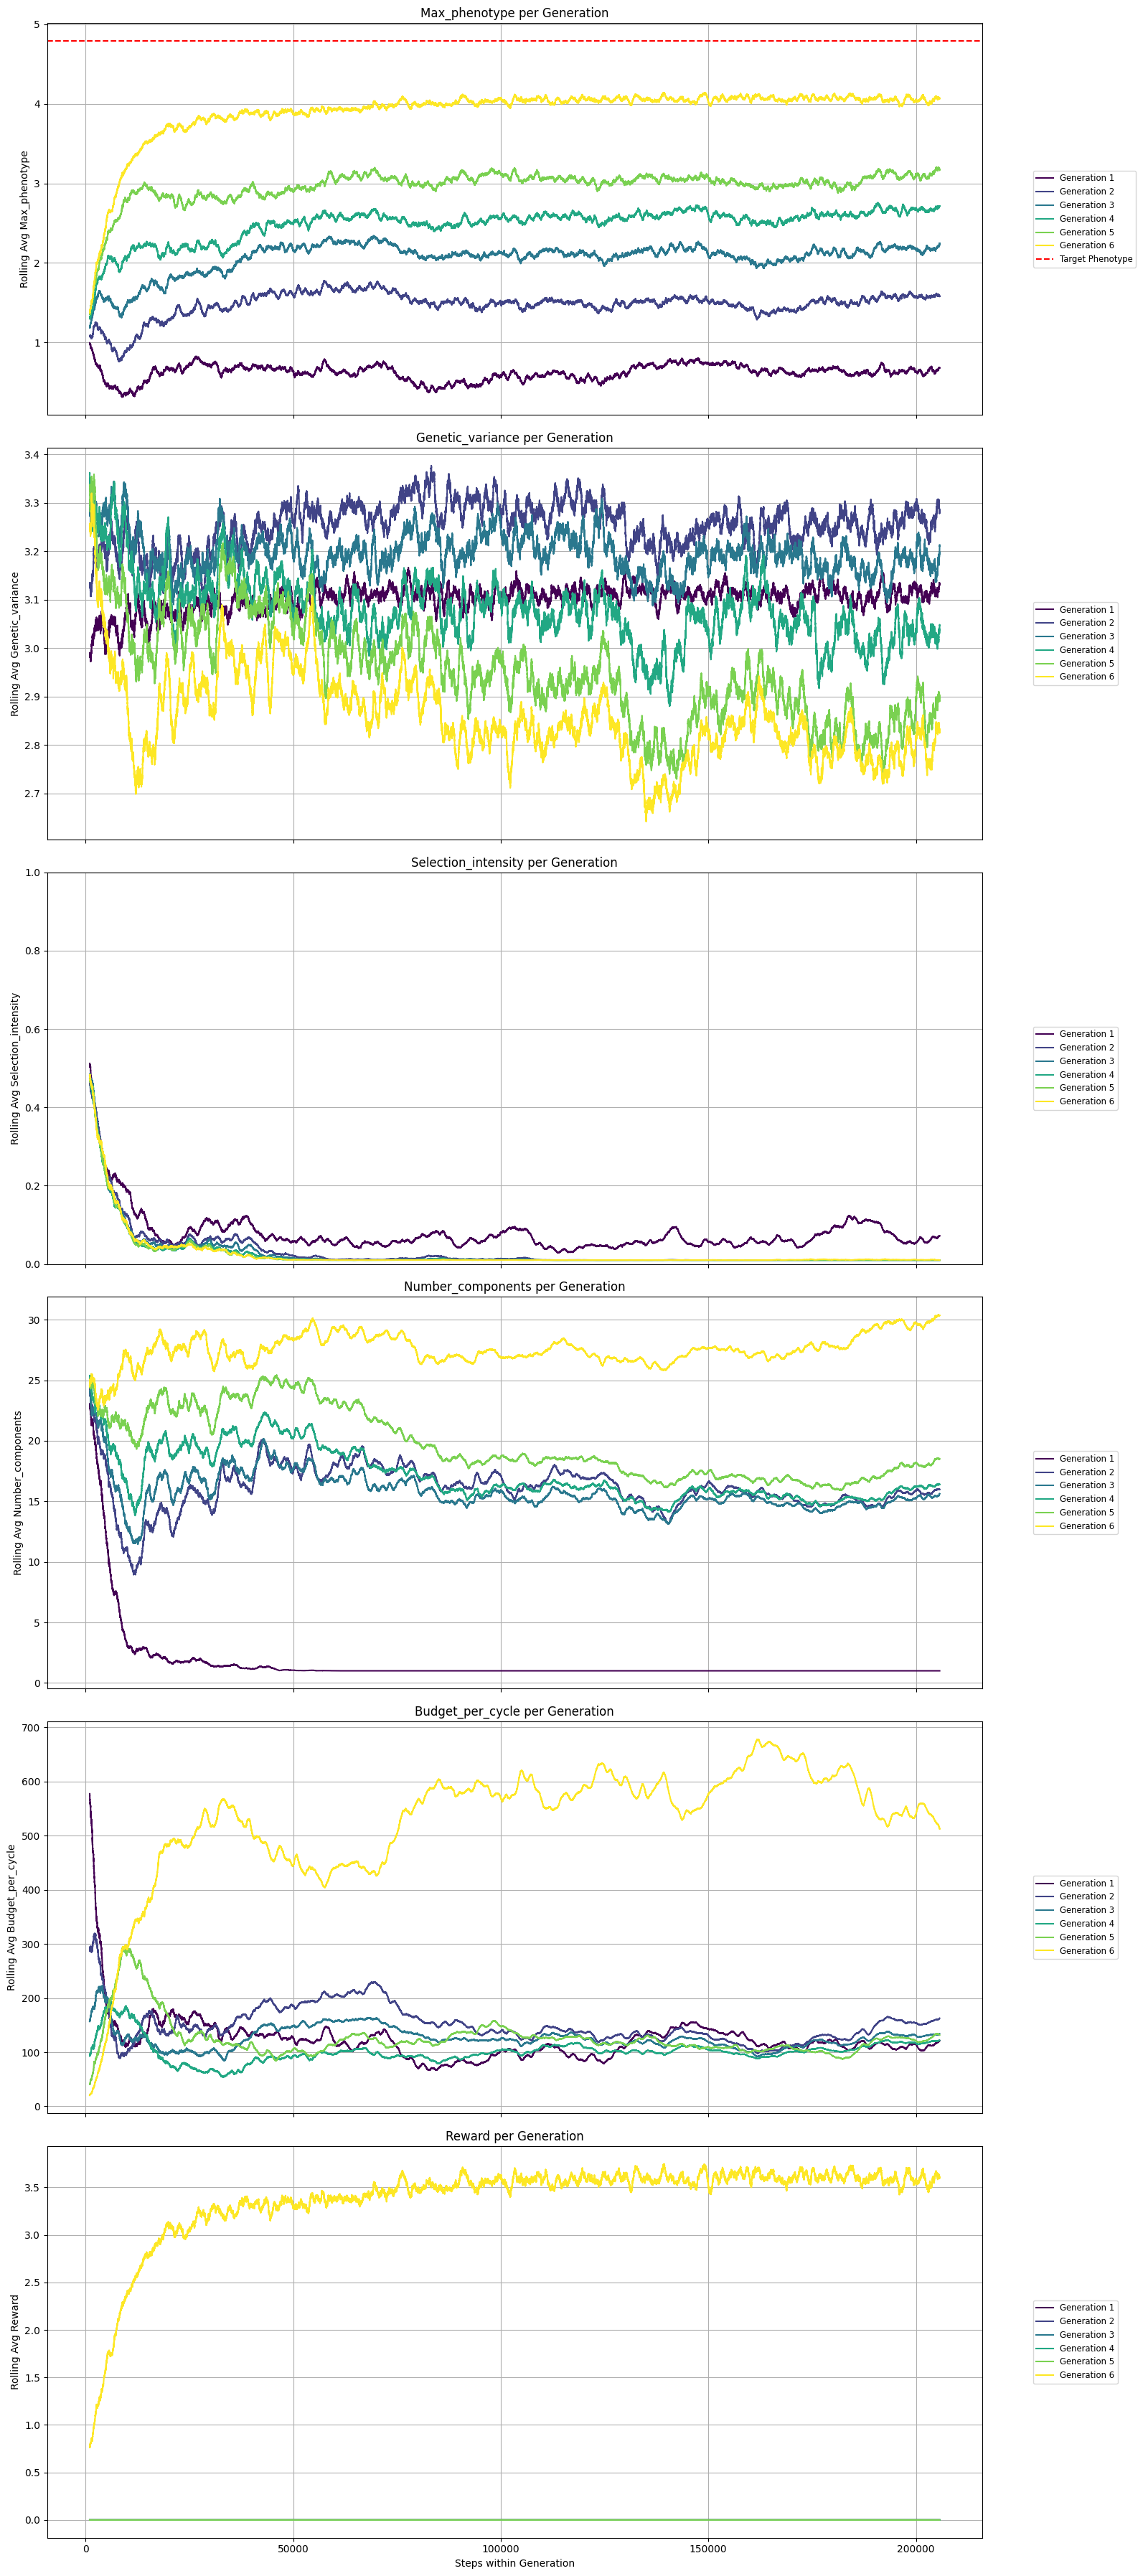

In [ ]:
# policy_kwargs = dict(log_std_init=-1.0)
breeder_model = PPO("MultiInputPolicy", breeding_env, device='cuda', verbose=1, seed = 2)
vis_callback = GeneralizedVisualizationCallback(log_freq=100, target_phenotype = result['avg_max_phenotype'])
breeder_model.learn(total_timesteps=config.total_timesteps, callback=vis_callback)

In [ ]:
breeder_model.learn(total_timesteps=50000, callback=vis_callback)